In [1]:
#!pip install segmentation-models

In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## part1: create super_stack of the data (skip to part2 if already done)

In [4]:
folder_path = '30_gut_annot_scarlet_edof_7_10_22'
file_list = os.listdir(folder_path)
file_list = [f for f in file_list if '4set' in f.lower()]
file_list

['StripA_b393G_b393R_simul_0hr1_devA1_1worm10_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA1_1worm13_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA1_1worm14_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA1_1worm8_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA2_1worm0_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA2_1worm11_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA2_1worm15_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA2_1worm4_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr1_devA2_1worm9_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr2_devA1_1worm0_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr2_devA1_1worm11_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr2_devA1_1worm12_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b393R_simul_0hr2_devA1_1worm15_edf_4set_worm_gut_mask.tiff',
 'StripA_b393G_b3

In [5]:
num_channels = 6
super_stack = np.empty((len(file_list), num_channels, 2048, 2048), dtype=np.uint16)

In [6]:
for i, file_name in enumerate(file_list):
    file_path = os.path.join(folder_path, file_name)
    image = tifffile.imread(file_path)
    super_stack[i] = image

super_file_name = 'super_stack_output.tiff'
output_file = os.path.join(folder_path, super_file_name)
tifffile.imsave(output_file, super_stack)

In [7]:
del super_stack

## part2: load superstack (skip to part3 if already have single channel stacks)

In [8]:
folder_path = '30_gut_annot_scarlet_edof_7_10_22'
super_file_name = 'super_stack_output.tiff'
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

In [9]:
img_stack.shape

(50, 6, 2048, 2048)

In [10]:
channel_names = {'0': 'bf',
'1' : 'edf w/ reassingment',
'2' : 'edf output',
'3' : 'hmap',
'4' : 'worm body mask',
'5' : 'gut mask'}
channel_names

{'0': 'bf',
 '1': 'edf w/ reassingment',
 '2': 'edf output',
 '3': 'hmap',
 '4': 'worm body mask',
 '5': 'gut mask'}

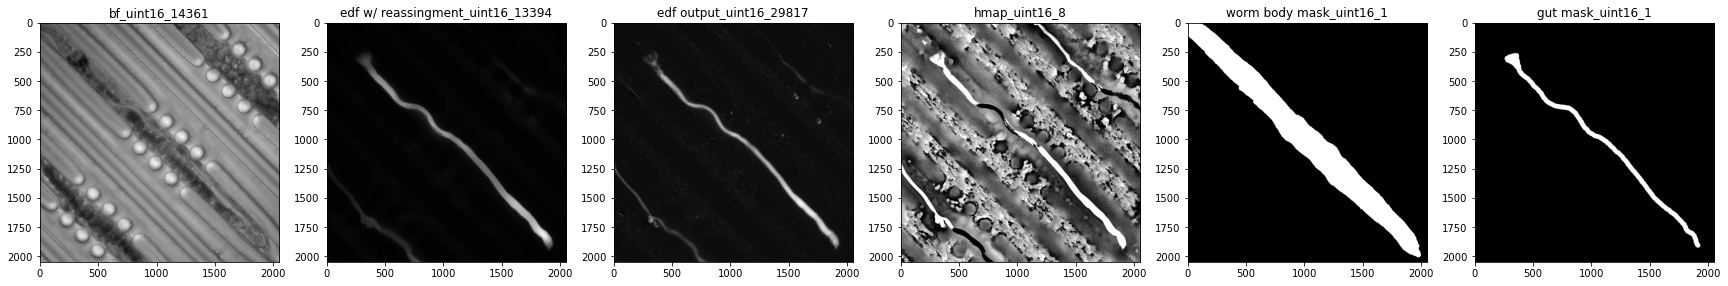

In [11]:
num_imgs = img_stack[0].shape[0]
fig, axs = plt.subplots(1,num_imgs, figsize=(num_imgs*5,5))
for i in range(num_imgs):
    img = img_stack[0][i]
    axs[i].imshow(img, cmap='gray')
    data_type = img.dtype
    val_range = np.ptp(img)
    title = '{}_{}_{}'.format(channel_names[str(i)],data_type,val_range)
    axs[i].title.set_text(title)
plt.show()

In [12]:
bf_stack = np.squeeze(img_stack[:, 0, :, :])
gutmask_stack = np.squeeze(img_stack[:, 5, :, :])
del img_stack


output_file = os.path.join(folder_path, 'bf_stack_only.tiff')
tifffile.imsave(output_file, bf_stack)

output_file = os.path.join(folder_path, 'gutmask_only.tiff')
tifffile.imsave(output_file, gutmask_stack)

## Part3: Open bf stack and gutmask_stack only

In [13]:

folder_path = '30_gut_annot_scarlet_edof_7_10_22'
bf_stack = tifffile.imread(os.path.join(folder_path, 'bf_stack_only.tiff'))
gutmask_stack = tifffile.imread(os.path.join(folder_path, 'gutmask_only.tiff'))

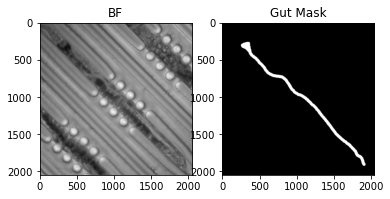

In [14]:
plt.subplot(1,2,1)
plt.imshow(bf_stack[0], cmap='gray')  # You can adjust the colormap as needed
plt.title('BF')
plt.subplot(1,2,2)
plt.imshow(gutmask_stack[0], cmap='gray')
plt.title('Gut Mask')
plt.show()

In [15]:
# def global_norm_data_float32(images):
#     images_float = images.astype(np.float32)
#     global_min = np.min(images_float)
#     global_max = np.max(images_float)
#     normalized_stack = (images_float - global_min) / (global_max - global_min)
#     return normalized_stack


# def preprocess_image(images):
#     images_float = images.astype(np.float32)/255.0
#     images_downsampled = block_reduce(images_float, (1, 2, 2), np.median)
    
#     return images_float

# def preprocess_mask(masks):
#     masks_float = masks.astype(np.float32)/255.0
#     masks_downsampled = block_reduce(masks_float, (1, 2, 2), np.median)
    
#     return masks_float

In [16]:
""" no norm here """

worm_imgs_norm = bf_stack.astype(np.float32) #global_norm_data_float32(bf_stack)
mask_imgs_norm = gutmask_stack.astype(np.float32) #lobal_norm_data_float32(gutmask_stack)

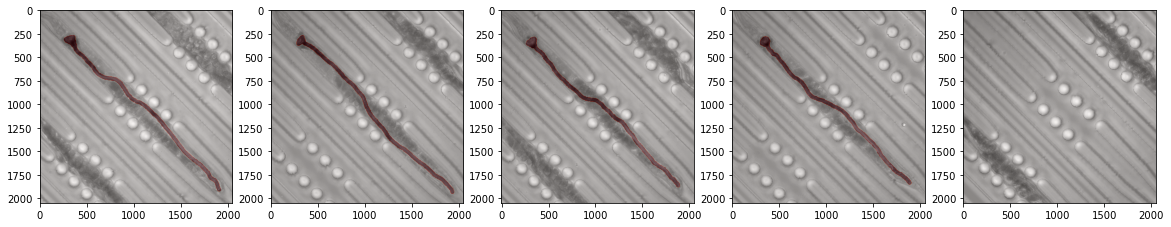

In [17]:
# Plotting a few images and masks to make sure they align
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    axs[i].imshow(worm_imgs_norm[i], cmap='gray')
    axs[i].imshow(mask_imgs_norm[i], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')

plt.show()

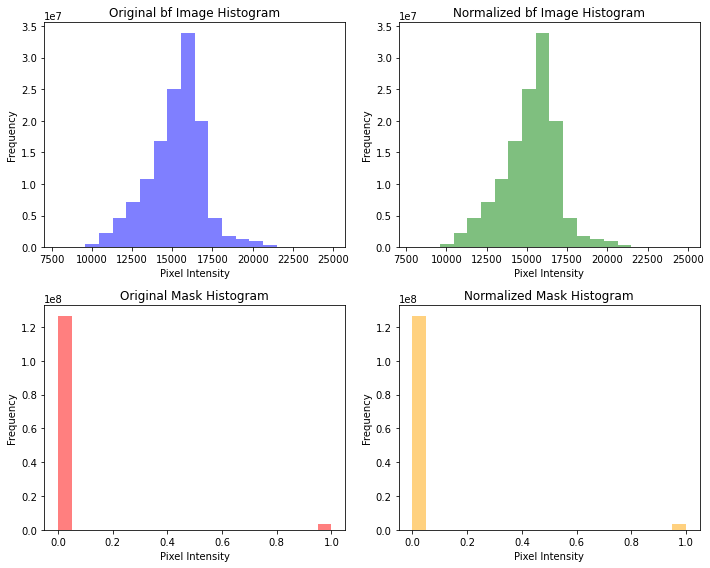

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].hist(bf_stack.flatten(), bins=20, color='blue', alpha=0.5)
axes[0, 0].set_title('Original bf Image Histogram')
axes[0, 0].set_xlabel('Pixel Intensity')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(worm_imgs_norm.flatten(), bins=20, color='green', alpha=0.5)
axes[0, 1].set_title(' not-Normalized bf Image Histogram')
axes[0, 1].set_xlabel('Pixel Intensity')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(gutmask_stack.flatten(), bins=20, color='red', alpha=0.5)
axes[1, 0].set_title('Original Mask Histogram')
axes[1, 0].set_xlabel('Pixel Intensity')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(mask_imgs_norm.flatten(), bins=20, color='orange', alpha=0.5)
axes[1, 1].set_title('not-Normalized Mask Histogram')
axes[1, 1].set_xlabel('Pixel Intensity')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

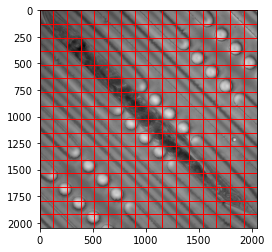

In [18]:
import matplotlib.patches as patches

def plot_image_with_patches(image, px, py, sx, sy):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    r, c = image.shape
    for x in range(0, r, sx):
        for y in range(0, c, sy):
            rect = patches.Rectangle((y, x), px, py, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    #plt.show()

plot_image_with_patches(worm_imgs_norm[3],256,256,128,128)

In [19]:
# plot_image_with_patches(worm_imgs_norm[3],128,128,64,64)
# resized_small_image = np.resize(block,(2048, 2048))
# plt.imshow(resized_small_image, cmap='Blues', alpha=0.7)


In [20]:
# resized_small_image = np.resize(block,(2048, 2048))
# resized_small_image.shape
# plt.imshow(resized_small_image)

## Extracting patches

mask patches: (50, 15, 15, 65536)
im patches: (50, 15, 15, 65536)


TensorShape([50, 15, 15, 65536])

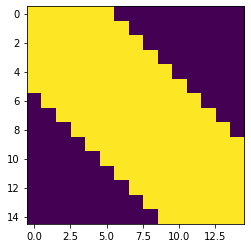

In [21]:

py = 256
px = 256
sy = 128
sx = 128


im_patches = tf.image.extract_patches(images=worm_imgs_norm[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sy, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches = tf.image.extract_patches(images=mask_imgs_norm[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sx, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

print('mask patches:',mask_patches.shape)
print('im patches:',im_patches.shape)
p_shape = im_patches.shape

block = np.ones((p_shape[1],p_shape[2]),dtype = np.float32)
triangle_size = 5
for i in range(block.shape[0]):
    for j in range(block.shape[1]):
        # Replace the pixels of the upper right triangle with the ones from the lower left triangle
        if j > i+triangle_size or i > j+triangle_size:
            block[i,j] = 0     #block[block.shape[0]-1-i,block.shape[1]-1-j]

block_exp = np.expand_dims(np.expand_dims(block,-1),0)
block_exp.shape
plt.imshow(block)

neg_im_patches = (im_patches+1)*block_exp-1 # unwanted patches will be all -1s
neg_mask_patches = (mask_patches+1)*block_exp-1 # unwanted masks will be all -1

neg_im_patches.shape


In [11]:
# # del im_patches
# # del mask_patches
# del neg_im_patches
# del neg_mask_patches

In [23]:
!nvidia-smi

Tue Aug  1 14:10:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:86:00.0 Off |                    0 |
| N/A   40C    P0    57W / 300W |  30714MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
# # gpu_devices = tf.config.list_physical_devices('GPU')
# # if gpu_devices:
# #     tf.config.experimental.get_memory_info(gpu_devices[0])['current']

# if tf.config.list_physical_devices('GPU'):
#   # Returns a dict in the form {'current': <current mem usage>,
#   #                             'peak': <peak mem usage>}
#     tf.config.experimental.get_memory_info('GPU:0')

In [28]:
neg_im_patches.dtype

tf.float32

### reconstruct patches just to see if patches were correctly excluded in the corner

(1, 2048, 2048, 1)
unwanted patches have -1 value


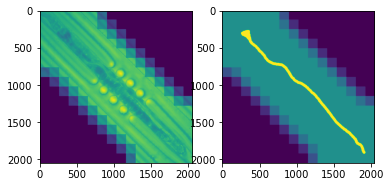

In [29]:
def reconstruct_from_patches(patches, img_shape, patch_size, stride):
    '''stride must be either equal to patch shape or a exact factor of it'''
    # Prepare an empty array to hold the accumulated patches
    img_reconstructed = np.zeros(img_shape, dtype=np.float32)
    counts = np.zeros(img_shape, dtype=np.float32)

    # Prepare indices for extracting patches
    idx_x = np.arange(0, img_shape[1]-patch_size[1]+1, stride[1])
    idx_y = np.arange(0, img_shape[2]-patch_size[2]+1, stride[2])
    i = 0
    for x in idx_x:
        for y in idx_y:
            patch = patches[0,i // len(idx_y), i % len(idx_y),:].numpy().reshape(patch_size)
            img_reconstructed[0, x:x+patch_size[1], y:y+patch_size[2], :] += patch[0]
            counts[0, x:x+patch_size[1], y:y+patch_size[2], :] += 1
            i += 1

    # Normalize by the counts
    img_reconstructed /= counts

    return img_reconstructed

unpatch_im = reconstruct_from_patches(neg_im_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))
unpatch_mask = reconstruct_from_patches(neg_mask_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))

print(unpatch_im.shape)
plt.subplot(1,2,1)
plt.imshow(unpatch_im[0,...,0])
plt.subplot(1,2,2)
plt.imshow(unpatch_mask[0,...,0])
print('unwanted patches have -1 value')

In [30]:
mask_patches_reshaped = np.array(tf.reshape(neg_mask_patches, [-1, py, px]))
mask_patches_reshaped.shape

im_patches_reshaped = np.array(tf.reshape(neg_im_patches, [-1, py, px]))
im_patches_reshaped.shape

(11250, 256, 256)

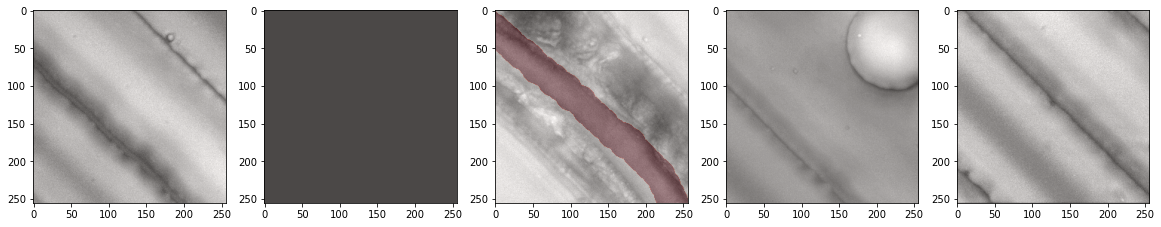

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(im_patches_reshaped[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [32]:
def check_mask(mask,frac,prob):
    if np.sum(mask)>mask.shape[0]*mask.shape[1]*frac:
        return 1
    elif np.random.uniform(0,1)<prob:
        return 1
    else:
        return 0
    
def check_mask_exclude_neg(mask,frac,prob):
    if mask[0,0] == -1:
        return 0
    elif np.sum(mask)>mask.shape[0]*mask.shape[1]*frac:
        return 1
    elif np.random.uniform(0,1)<prob:
        return 1
    else:
        return 0

frac = 0 # fraction of mask pixels needed to definitely include
prob = 0.15 # fraction of patches with no/low mask pixels to include anyway

accepted_masks = [check_mask_exclude_neg(m,frac,prob) for m in mask_patches_reshaped]
print('fraction accepted: ', sum(accepted_masks)/mask_patches_reshaped.shape[0])

mask_patches_sub = np.array([m for i,m in enumerate(mask_patches_reshaped) if accepted_masks[i]==1])
img_patches_sub = np.array([m for i,m in enumerate(im_patches_reshaped) if accepted_masks[i]==1])

print(mask_patches_sub.shape,mask_patches_sub.dtype)
print(img_patches_sub.shape,img_patches_sub.dtype)

fraction accepted:  0.3072888888888889
(3457, 256, 256) float32
(3457, 256, 256) float32


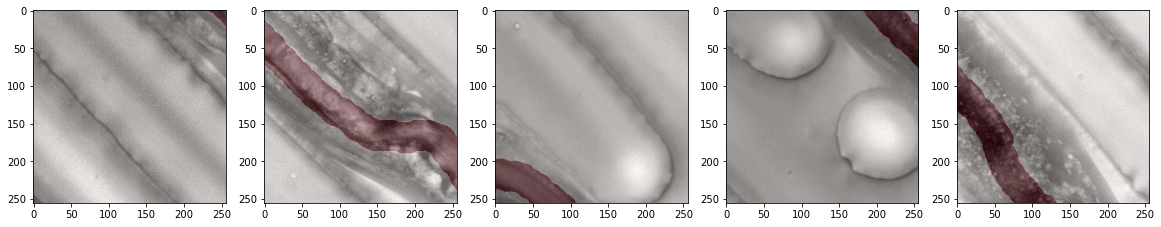

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(img_patches_sub[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [34]:


output_file = os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set4.tiff')
tifffile.imsave(output_file, img_patches_sub)

output_file = os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set4.tiff')
tifffile.imsave(output_file, mask_patches_sub)

### part4 open patches

In [3]:

folder_path = '30_gut_annot_scarlet_edof_7_10_22'
img_patches_sub = tifffile.imread(os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set4.tiff'))
mask_patches_sub = tifffile.imread(os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set4.tiff'))

(array([1.5387200e+05, 4.6549660e+06, 3.1772434e+07, 6.2905905e+07,
        8.4306046e+07, 3.5756598e+07, 4.7424480e+06, 2.0736950e+06,
        1.9180200e+05, 1.8600000e+02]),
 array([ 7583. ,  9314.2, 11045.4, 12776.6, 14507.8, 16239. , 17970.2,
        19701.4, 21432.6, 23163.8, 24895. ], dtype=float32),
 <BarContainer object of 10 artists>)

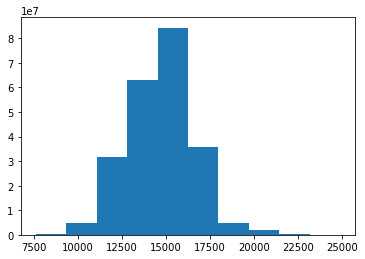

In [4]:
plt.hist(img_patches_sub.flatten(),bins = 10)

In [5]:
def center_norm_im_float32(images):
    images_float = images.astype(np.float32)
    mean = np.mean(images_float)
    std = np.std(images_float)
    normalized_stack = (images_float-mean)/std
    return normalized_stack
img_patches_sub = center_norm_im_float32(img_patches_sub)
mask_patches_sub = mask_patches_sub.astype(np.float32)



(array([1.5387200e+05, 4.6549660e+06, 3.1772434e+07, 6.2905905e+07,
        8.4360555e+07, 3.5702089e+07, 4.7424480e+06, 2.0736950e+06,
        1.9180200e+05, 1.8600000e+02]),
 array([-3.8739152 , -2.930488  , -1.9870613 , -1.0436342 , -0.10020723,
         0.84321976,  1.7866467 ,  2.7300737 ,  3.6735008 ,  4.6169276 ,
         5.5603547 ], dtype=float32),
 <BarContainer object of 10 artists>)

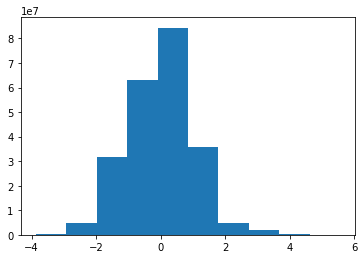

In [6]:
plt.hist(img_patches_sub.flatten(),bins = 10)

In [7]:
np.max(img_patches_sub)

5.5603547

In [8]:
img_patches_sub.dtype

dtype('float32')

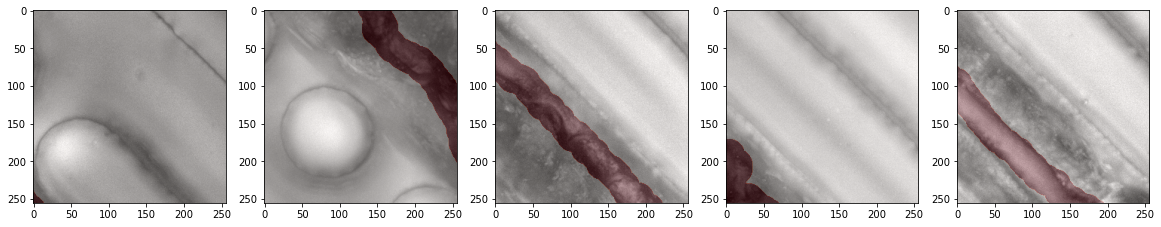

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,img_patches_sub.shape[0])
    axs[i].imshow(img_patches_sub[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_patches_sub, mask_patches_sub, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(2592, 256, 256)
(865, 256, 256)


In [11]:
X_train = np.stack((X_train,)*1, axis=-1)
y_train = np.stack((y_train,)*1, axis=-1)

print(X_train.shape)
print(y_train.shape)

(2592, 256, 256, 1)
(2592, 256, 256, 1)


In [12]:
X_test = np.stack((X_test,)*1, axis=-1)
y_test = np.stack((y_test,)*1, axis=-1)
print(X_test.shape)
print(y_test.shape)

(865, 256, 256, 1)
(865, 256, 256, 1)


dtype('float32')

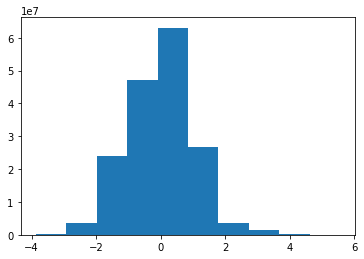

In [13]:
plt.hist(X_train.flatten(),bins = 10)
X_train.dtype

In [14]:
#New generator with rotation where interpolation that comes with rotation are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
batch_size = 32

img_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))
                         #featurewise_center = True,
                         #featurewise_std_normalization = True)#,
                         #preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))


mask_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         brightness_range = (0.95,1.05),
                         preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed,batch_size = batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed,batch_size = batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed,batch_size = batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed,batch_size = batch_size)

In [15]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_gen = my_image_mask_generator(image_generator,mask_generator)
test_gen = my_image_mask_generator(valid_img_generator,valid_mask_generator)

x batch: (32, 256, 256, 1)
y batch: (32, 256, 256, 1)


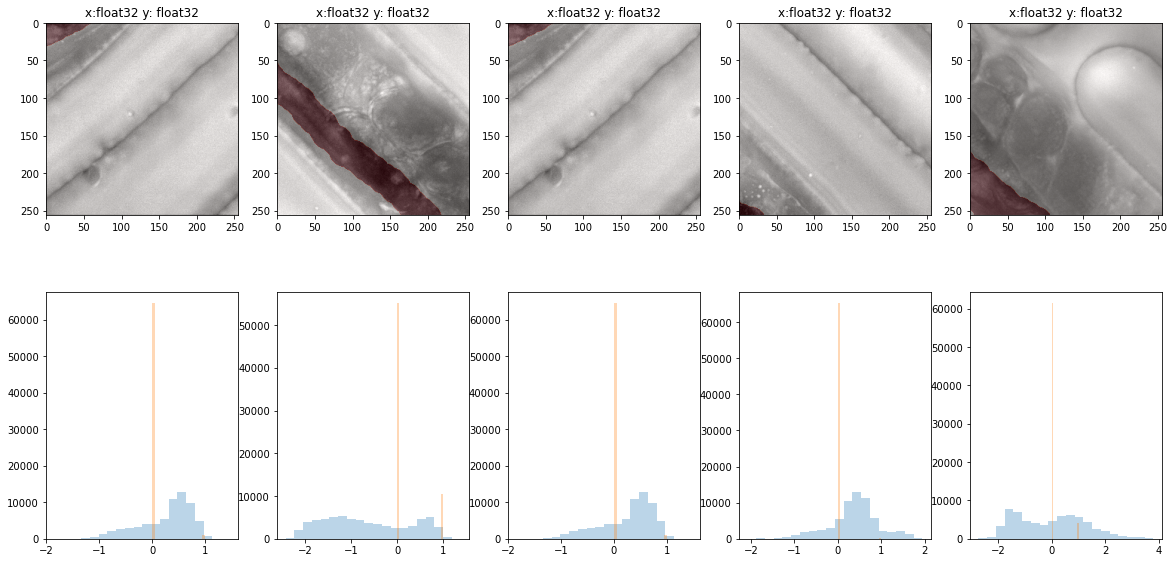

In [16]:
x = image_generator.next()
y = mask_generator.next()

print('x batch:', x.shape)
print('y batch:', y.shape)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,32)
    axs[0,i].imshow(x[ri,...,0], cmap='gray')
    axs[0,i].imshow(y[ri,...,0], cmap='Reds', alpha=0.3)
    axs[0,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
#     axs[1,i].imshow(x[ri+1,...,0], cmap='gray')
#     axs[1,i].imshow(y[i+1,...,0], cmap='Reds', alpha=0.3)
#     axs[1,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
    axs[1,i].hist(x[ri,...,0].flatten(), bins = 20,alpha = 0.3)
    axs[1,i].hist(y[ri,...,0].flatten(), bins = 20,alpha = 0.3)

plt.show()

In [17]:
x[0,0,0,0]

0.55092674

(array([1954454.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  142698.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

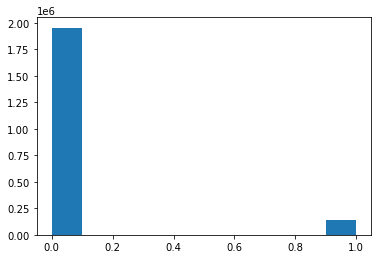

In [18]:
plt.hist(y[...,0].flatten())

In [19]:
# x = image_generator.next()
# y = mask_generator.next()

# print('x batch:', x.shape)
# print('y batch:', y.shape)

# fig, axs = plt.subplots(2, 5, figsize=(20, 6))  # 1 row, 5 columns

# for i in range(5):
#     # show grayscale images

#     #ri = np.random.randint(0,32)
#     axs[0,i].imshow(x[i,...,0], cmap='gray')
#     axs[0,i].imshow(y[i,...,0], cmap='Reds', alpha=0.3)
#     axs[0,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
#     axs[1,i].imshow(x[i+1,...,0], cmap='gray')
#     axs[1,i].imshow(y[i+1,...,0], cmap='Reds', alpha=0.3)
#     axs[1,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
# #     axs[1,i].hist(x[ri,...,0].flatten(), bins = 20,alpha = 0.3)
# #     axs[1,i].hist(y[ri,...,0].flatten(), bins = 20,alpha = 0.3)

# plt.show()

In [19]:
N = x.shape[-1]

# define the model
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet',encoder_freeze=True)
inp = Input(shape =(None,None, N))
l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
out = base_model(l1)
model = Model(inp, out, name=base_model.name)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

# checkpoint path
checkpoint_path = 'models/bf_to_gut_tl/set4_50im_patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True,mode='min')

# logdirectory
log_fname = 'models/bf_to_gut_tl/set4_50im_patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.csv'
csvlogger = CSVLogger(filename=log_fname, separator=",", append=True)

directory = os.path.dirname(log_fname)
if not os.path.exists(directory):
    os.makedirs(directory)
with open(log_fname, 'w') as f:
    pass

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     6         
_________________________________________________________________
model_1 (Model)              (None, None, None, 1)     14340570  
Total params: 14,340,576
Trainable params: 3,159,642
Non-trainable params: 11,180,934
_________________________________________________________________


In [21]:
history1 = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=4,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/4
81/81 [==============================] - 15s 187ms/step - loss: 1.1172 - iou_score: 0.1867 - val_loss: 1.3342 - val_iou_score: 0.0241
Epoch 2/4
81/81 [==============================] - 15s 182ms/step - loss: 0.8750 - iou_score: 0.3169 - val_loss: 1.3747 - val_iou_score: 0.0124
Epoch 3/4
81/81 [==============================] - 14s 167ms/step - loss: 0.7760 - iou_score: 0.3956 - val_loss: 1.5357 - val_iou_score: 0.0027
Epoch 4/4
81/81 [==============================] - 14s 169ms/step - loss: 0.7190 - iou_score: 0.4441 - val_loss: 1.6305 - val_iou_score: 7.9879e-04


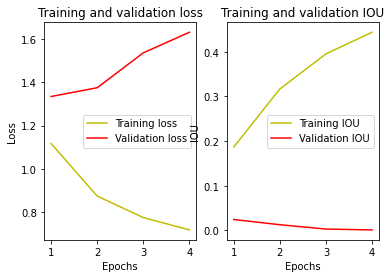

In [22]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.subplot(121)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history1.history['iou_score']
#acc = history.history['accuracy']
val_acc = history1.history['val_iou_score']
#val_acc = history.history['val_accuracy']
plt.subplot(122)
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [23]:
# from segmentation_models.utils import set_trainable
# set_trainable(model)

In [24]:
# set all layers trainable and recompile with same call to compile as before
for layer in model.layers:
    layer.trainable = True
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
# default learning rate is 0.0001

In [25]:
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=60,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/60
81/81 [==============================] - 15s 186ms/step - loss: 0.7821 - iou_score: 0.3954 - val_loss: 3.1535 - val_iou_score: 1.2756e-04
Epoch 2/60
81/81 [==============================] - 14s 178ms/step - loss: 0.6787 - iou_score: 0.4780 - val_loss: 2.3608 - val_iou_score: 1.0865e-04
Epoch 3/60
81/81 [==============================] - 15s 180ms/step - loss: 0.6175 - iou_score: 0.5234 - val_loss: 1.8691 - val_iou_score: 1.2303e-04
Epoch 4/60
81/81 [==============================] - 14s 179ms/step - loss: 0.5790 - iou_score: 0.5537 - val_loss: 2.1067 - val_iou_score: 2.9861e-05
Epoch 5/60
81/81 [==============================] - 15s 182ms/step - loss: 0.5418 - iou_score: 0.5831 - val_loss: 1.9317 - val_iou_score: 2.8766e-05
Epoch 6/60
81/81 [==============================] - 14s 178ms/step - loss: 0.5205 - iou_score: 0.5989 - val_loss: 1.9452 - val_iou_score: 1.8548e-05
Epoch 7/60
81/81 [==============================] - 14s 179ms/step - loss: 0.5015 - iou_score: 0.6129 - va

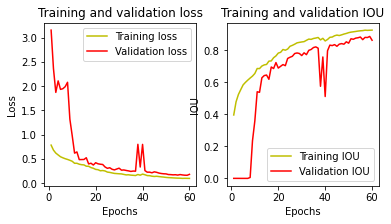

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize = [6,3])
plt.subplot(121)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']
plt.subplot(122)
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()



In [27]:
model.load_weights(checkpoint_path)

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8859915208254067


In [36]:
model.load_weights(checkpoint_path)

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8720188252303179


(256, 256, 1)


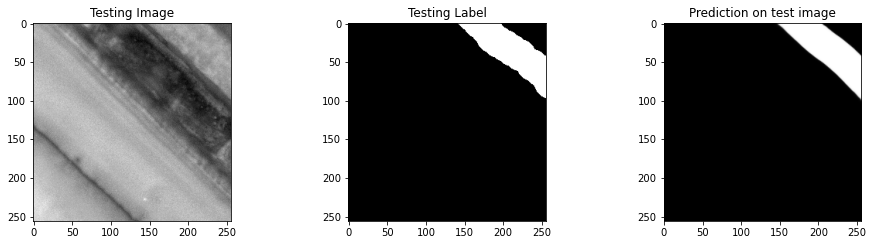

In [28]:

test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=30,
                    callbacks=[checkpoint,csvlogger])

In [32]:
worm_imgs_norm = center_norm_im_float32(worm_imgs_norm) #global_norm_data_float32(bf_stack)
mask_imgs_norm = mask_imgs_norm.astype(np.float32)

4.2384415

23


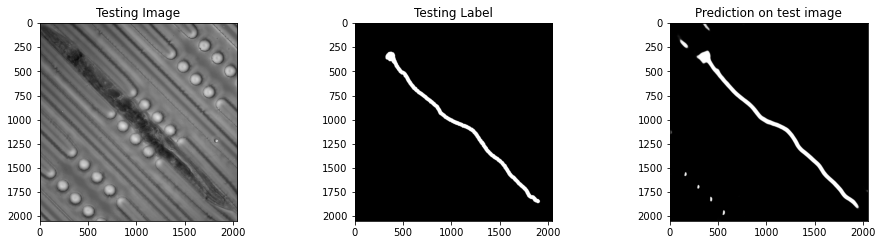

In [34]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
print(test_img_number)
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

4


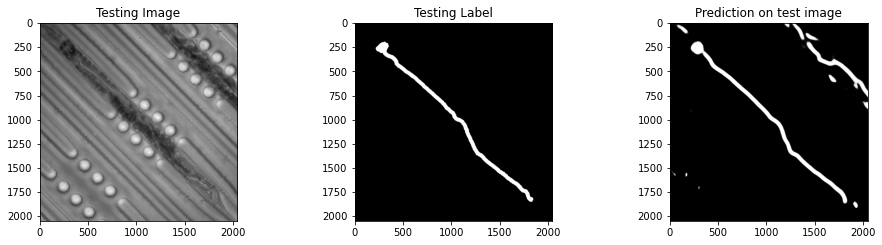

In [35]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
print(test_img_number)
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [61]:
model.load_weights('models/bf_to_gut_tl/sel_patches_backresnet18_weightimagenet_v1.hdf5')


In [62]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8341554104238993


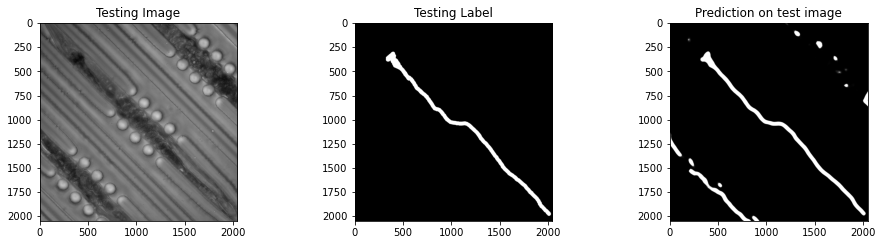

In [63]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

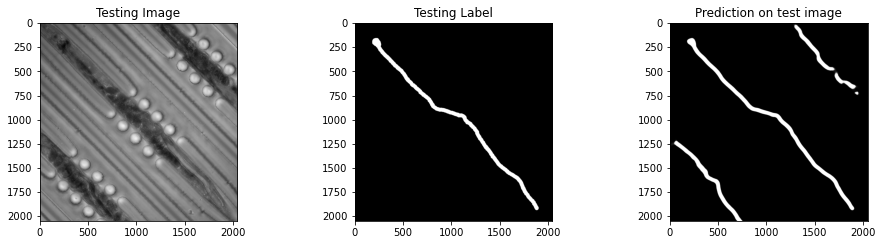

In [64]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

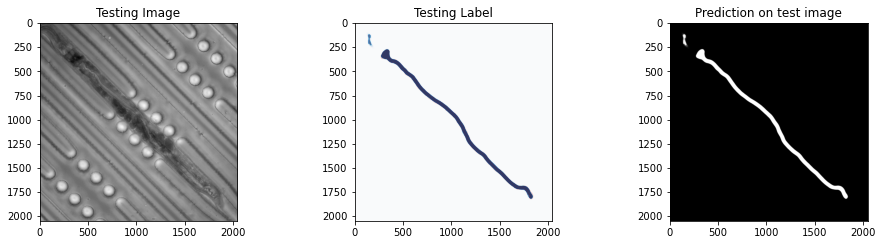

In [67]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='Reds',alpha = 0.7)
plt.imshow(prediction, cmap='Blues',alpha = 0.7)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [80]:
annot_dir = 'soph_annot_bact_noPool_7_22_23'
annot_file_list = os.listdir(annot_dir)
annot_file_list

s1 = tifffile.imread(os.path.join(annot_dir,annot_file_list[3]))
s1.shape

(4, 2048, 2048)

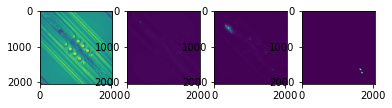

In [81]:
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(s1[i])

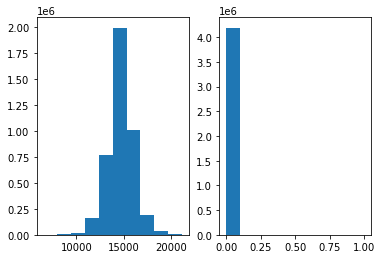

In [82]:
plt.subplot(1,2,1)
plt.hist(s1[0].flatten(),bins = 10);
plt.subplot(1,2,2)
plt.hist(s1[3].flatten(),bins = 10);


In [83]:
bf_norm = global_norm_data_float32(s1[:1,...])

In [84]:
test_img = np.stack((bf_norm,)*1, axis=-1)
test_img.shape

(1, 2048, 2048, 1)

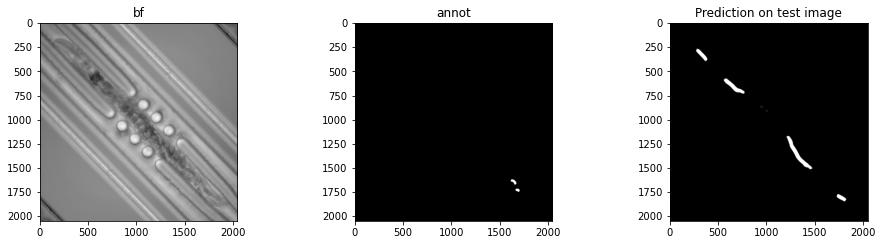

In [85]:



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('bf')
plt.imshow(test_img[0,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('annot')
plt.imshow(s1[3], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(model.predict(test_img)[0,...,0], cmap='gray')